In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import pandas
import rasterio
from osgeo import gdal
import geopandas as gpd
from sklearn.linear_model import LinearRegression

/home/luckyw0w/.local/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
df = pd.read_csv("StateWiseData/MaharashtraData.csv")
df.columns = df.columns.map(str)

In [6]:
df.head(2)

,index,0,1,2,3,4,5,6,7,8,...,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003
0,0,2.549002,2.829386,2.829386,3.751292,4.225150,2.257778,3.173797,3.163928,3.163928,...,2.116667,2.116667,2.357201,1.847273,1.847273,2.178894,2.532894,2.532894,2.125161,2.192698
1,1,4.188626,3.091398,3.091398,4.527487,6.681919,4.198399,3.451913,2.927097,2.927097,...,7.561326,7.561326,5.984145,6.350387,1.847273,2.982864,5.280305,5.280305,7.252660,2.364489


In [12]:
data_len = int(len(df.columns))-1
print(data_len)

2004


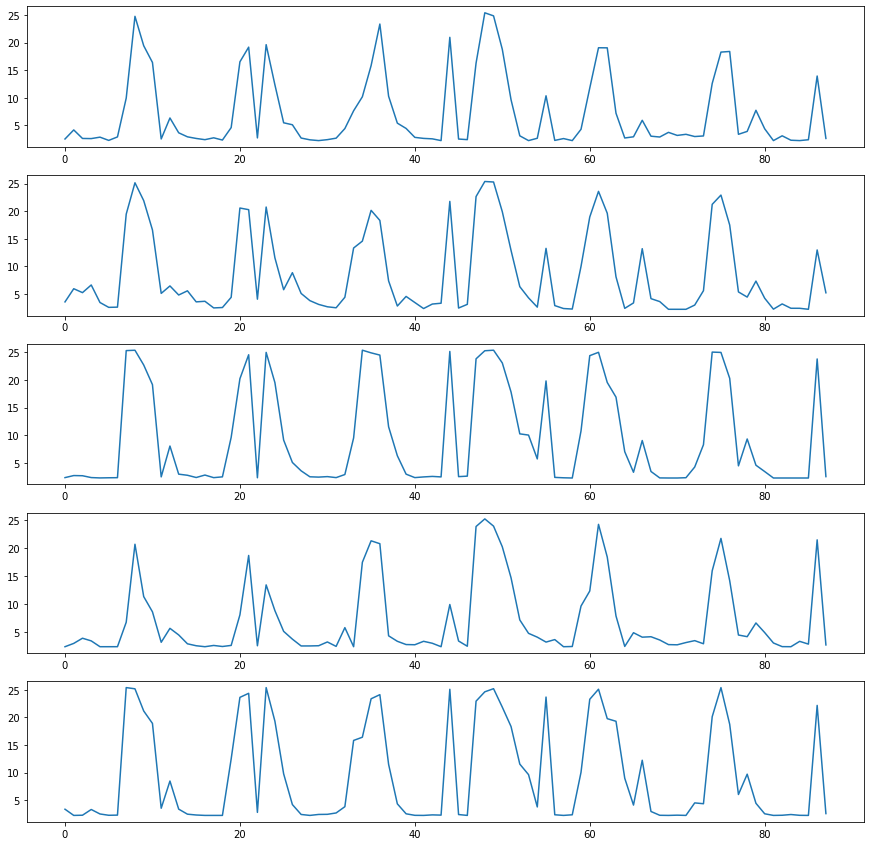

In [13]:
#plotting trends in 5 pixels
fig, ax = plt.subplots(5, figsize=(15, 15))
for i in range(0,5):
    ax[i].plot(df[str(i*10)])

### For Every pixel value (27km^2 grids) available of the geography, we calculate a deviance score using Linear Regression, for the period of 84 months starting from March 2015 to March 2022.   

In [14]:
scores = []

for i in range(0,data_len):
    
    X = np.array(df['index'])
    #print(X)
    X = X.reshape(-1, 1)
    #print(X)
    i = str(i)
    #print(df[i])
    y = np.array(df[i])
    y = y.reshape(-1, 1)

    #Perform Linear Regression and obtain the slope
    reg = LinearRegression().fit(X, y)
    y_pred_trend = reg.predict(X)
    slope, intercept = np.polyfit(np.array(df['index']), y_pred_trend,1)
    line_slope = slope[0]

    scores.append(line_slope)

In [15]:
len(scores)

2004

In [16]:
#Imbibe score values into the coordinates
coordinates = pd.read_csv("Maharashtracoordinates.csv")
coordinates["values"] = scores
coordinates["latitude"] = coordinates["y"]
coordinates["longitude"] = coordinates["x"]

In [17]:
print("max:", coordinates["values"].max(), "min:", coordinates["values"].min())

max: 0.05355540844898031 min: -0.044048973212461706


In [25]:
import rioxarray
df2 = coordinates[['latitude','longitude']]
df2['value'] = list(coordinates['values'])
da = df2.set_index(['latitude', 'longitude']).to_xarray()
da = da.set_coords(['latitude', 'longitude'])
da.rio.to_raster('MaharashtraSoilMoistureDeviance.tif')

C:\Users\007sh\AppData\Local\Temp\ipykernel_9348\4275142142.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['value'] = list(coordinates['values'])


### Visualizing the Deviance (Change in soil moisture over 7 years) in Soil Moisture

In [26]:
from osgeo import gdal
import matplotlib.pyplot as plt
from osgeo import osr

spatref = osr.SpatialReference()
spatref.ImportFromEPSG(4326)
crs_wkt = spatref.ExportToWkt()

dataset = gdal.Open('MaharashtraSoilMoistureDeviance.tif', gdal.GA_ReadOnly) 
dataset.SetProjection(crs_wkt)
band = dataset.GetRasterBand(1)
arr = band.ReadAsArray()

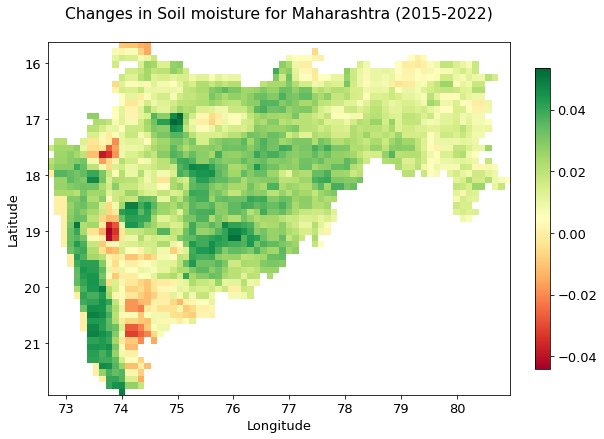

In [27]:
geotransform = dataset.GetGeoTransform()

originX,pixelWidth,empty,finalY,empty2,pixelHeight=geotransform
cols =  dataset.RasterXSize
rows =  dataset.RasterYSize

projection = dataset.GetProjection()

finalX = originX + pixelWidth * cols
originY = finalY + pixelHeight * rows

extentArray = [originX,finalX,originY,finalY]

plt.figure(figsize=(9,9))

im = plt.imshow(arr, cmap= "RdYlGn", extent=extentArray, origin="lower")
plt.colorbar(im, fraction=0.03)
#plt.gca().invert_yaxis()

plt.rcParams.update({'font.size': 13})
plt.title("Changes in Soil moisture for Maharashtra (2015-2022)\n")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
print(" ")
plt.show()